In [119]:
import os
import re
import csv

import requests
from requests.exceptions import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Etapa de verificação do arquivo robots.txt do github.

In [120]:
def crawl_website(url: str) -> str:

  try:
    resposta = requests.get(url)
    resposta.raise_for_status()
  except HTTPError as exc:
    print(exc)
  else:
    return resposta.text

URL = 'https://github.com/robots.txt'

robots = crawl_website(url=URL)

if  re.findall('ranking', robots, re.IGNORECASE) == True or re.findall('project', robots, re.IGNORECASE) == False:
  print(True) 
else:
  print(False) 

False


Importação das informações do site para ler com o python.

In [121]:
URL = 'https://github.com/trending'
pagina = crawl_website(url=URL)

pagina = BeautifulSoup(conteudo, 'html.parser')
projetos = pagina.find_all('article', {'class': 'Box-row'})

In [122]:
dados = []
for projeto in projetos:
    nome_projeto = projeto.find('h2').text.split()[0]
    nome_dev = projeto.find('h2').text.split()[2] 
    linguagem = projeto.find('span',{'itemprop':'programmingLanguage'})
    if linguagem == None:
        linguagem = None
    else:
        linguagem = linguagem.text

    bloco_geral = projeto.find('div',{'class':'f6 color-fg-muted mt-2'}).text.split()
    estrelas = bloco_geral[-7].replace(',','')
    estrelas_hoje = bloco_geral[-3].replace(',','')
    forks = bloco_geral[-6].replace(',','')

    dados.append([nome_projeto, nome_dev, linguagem, int(estrelas), int(estrelas_hoje),int(forks)])

print(dados)    

[['qdrant', 'qdrant', 'Rust', 7907, 474, 384], ['pineappleEA', 'pineapple-src', 'C++', 1765, 82, 158], ['mosaicml', 'llm-foundry', 'Python', 890, 151, 45], ['skyline-emu', 'skyline', 'C++', 12735, 35, 1644], ['bigcode-project', 'starcoder', 'Python', 2527, 367, 135], ['openai', 'shap-e', 'Python', 3996, 371, 206], ['xiangsx', 'gpt4free-ts', 'TypeScript', 126, 39, 53], ['GreyDGL', 'PentestGPT', 'Python', 2759, 136, 264], ['azerothcore', 'azerothcore-wotlk', 'C++', 3093, 16, 1694], ['tatsu-lab', 'stanford_alpaca', 'Python', 23160, 115, 3316], ['ellie', 'atuin', 'Rust', 8721, 760, 245], ['AntonioErdeljac', 'next13-messenger', 'TypeScript', 85, 43, 31], ['shchmue', 'Lockpick_RCM', 'C', 1194, 81, 190], ['shchmue', 'Lockpick', 'C', 513, 33, 110], ['eugeneyan', 'open-llms', None, 1300, 195, 75], ['adrianhajdin', 'project_next_13_ai_prompt_sharing', 'JavaScript', 166, 32, 36], ['nadermx', 'backgroundremover', 'Python', 3455, 361, 297], ['Atmosphere-NX', 'Atmosphere', 'C++', 11372, 19, 1046], [

In [128]:
# Criação do arquivo em CSV, caso seja preciso
with open('github.csv', 'w', newline='', encoding='utf-8') as arquivo:
    writer = csv.writer(arquivo, delimiter=';')
    writer.writerow(['nome_projeto', 'nome_dev', 'linguagem', 'estrelas', 'estrelas_hoje,forks'])
    writer.writerows(dados)

Criação do dataframe Pandas

In [124]:
github_df = pd.DataFrame(dados, columns=['nome_projeto', 'nome_dev', 'linguagem', 'estrelas', 'estrelas_hoje', 'forks'])
github_df.head(10)

,nome_projeto,nome_dev,linguagem,estrelas,estrelas_hoje,forks
0,qdrant,qdrant,Rust,7907,474,384
1,pineappleEA,pineapple-src,C++,1765,82,158
2,mosaicml,llm-foundry,Python,890,151,45
3,skyline-emu,skyline,C++,12735,35,1644
4,bigcode-project,starcoder,Python,2527,367,135
5,openai,shap-e,Python,3996,371,206
6,xiangsx,gpt4free-ts,TypeScript,126,39,53
7,GreyDGL,PentestGPT,Python,2759,136,264
8,azerothcore,azerothcore-wotlk,C++,3093,16,1694
9,tatsu-lab,stanford_alpaca,Python,23160,115,3316


In [125]:
# Existe valores nulos na coluna 'linguagem', mas eles não afetarão no resultado final
github_df.isnull().any()

nome_projeto     False
nome_dev         False
linguagem         True
estrelas         False
estrelas_hoje    False
forks            False
dtype: bool

In [135]:
# Criação de um novo dataframe com os dados focados para a coluna 'linguagem'
linguagem_df = github_df[['linguagem','estrelas','estrelas_hoje','forks']]
linguagem_df['qtde_projetos'] = 1
linguagem_df = linguagem_df.groupby('linguagem').agg('sum').reset_index()
linguagem_df

C:\Users\caiom\AppData\Local\Temp\ipykernel_376\1291590472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linguagem_df['qtde_projetos'] = 1


,linguagem,estrelas,estrelas_hoje,forks,qtde_projetos
0,C,1707,114,300,2
1,C++,28965,152,4542,4
2,JavaScript,166,32,36,1
3,Python,129437,2295,20253,9
4,Rust,16628,1234,629,2
5,TypeScript,11630,305,1514,5


Text(0.5, 1.0, 'GitHub Trending: Quantidade de projetos por linguagem')

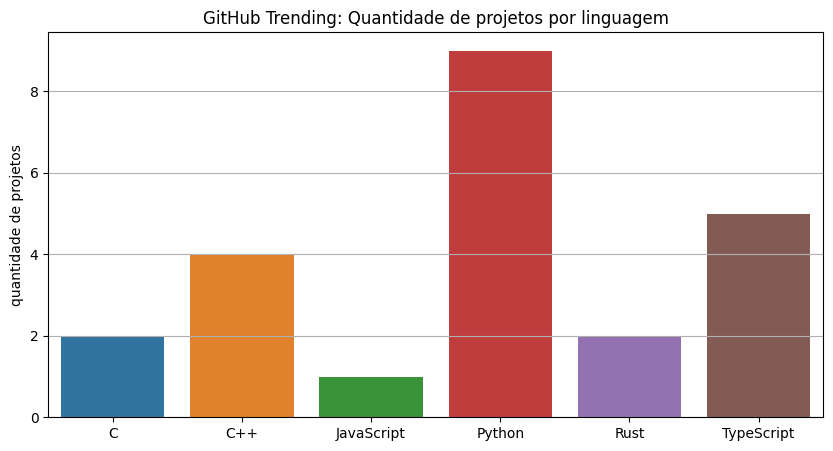

In [131]:
plt.figure(figsize=(10,5))
plt.grid()

grafico = sns.barplot(data=linguagem_df, x='linguagem',y='qtde_projetos')
grafico.set(xlabel=None,ylabel='quantidade de projetos')

plt.title("GitHub Trending: Quantidade de projetos por linguagem", fontsize = 12) 


Text(0.5, 1.0, 'GitHub Trending: Quantidade de estrelas hoje por linguagem')

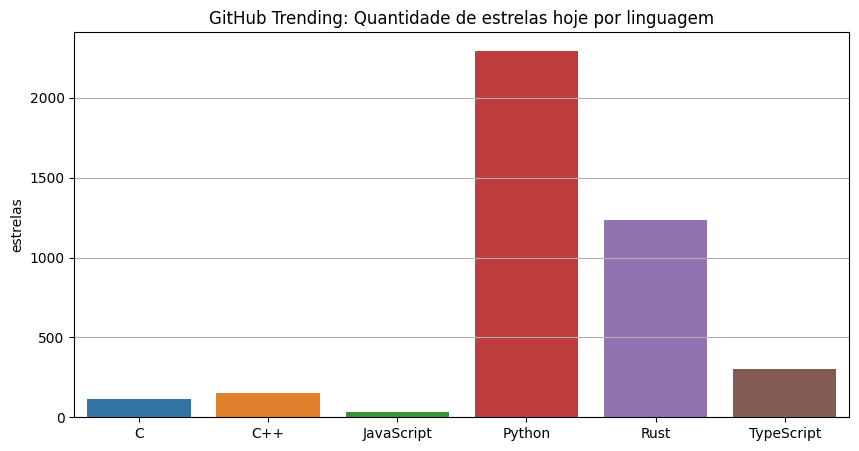

In [134]:
plt.figure(figsize=(10,5))
plt.grid()

grafico = sns.barplot(data=linguagem_df, x='linguagem',y='estrelas_hoje')
grafico.set(xlabel=None,ylabel='estrelas')

plt.title("GitHub Trending: Quantidade de estrelas hoje por linguagem", fontsize = 12) 